In [37]:
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset
import matplotlib.pyplot as plt
from transformers import DistilBertModel, DistilBertTokenizer
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

# Glossaires
* `emotions`: Jeu de données original sous la forme d'un DatasetDict
* `emotions_encoded`: Idem que `emotions`, mais contient en plus les tokens et le mask. (input_ids, mask)
* `emotions_hidden`: Dernière couche cachée qui contient les embeddings construit par un passage des données dans l'encodeur (distillbert)

# Load and explore the data

In [2]:
emotions = load_dataset('emotion')

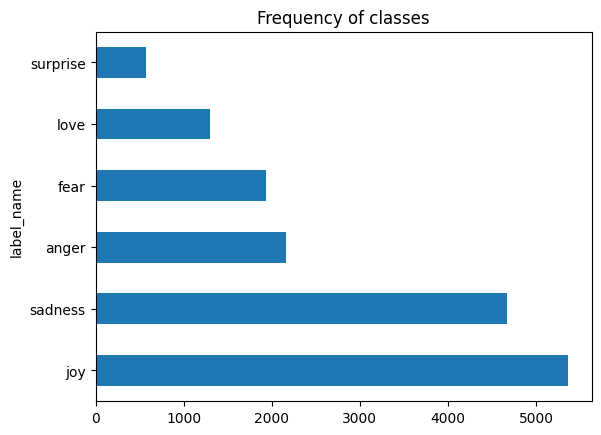

In [3]:
emotions.set_format(type='pandas')
df = emotions['train'][:]
emotions.reset_format()

def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)

df['label_name'] = df['label'].apply(label_int2str)

df['label_name'].value_counts(ascending=False).plot.barh()
plt.title('Frequency of classes')
plt.show()

# Tokenize

In [4]:
print(emotions.column_names)

{'train': ['text', 'label'], 'validation': ['text', 'label'], 'test': ['text', 'label']}


In [5]:
mdl_ckpt = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_model_name_or_path=mdl_ckpt)

def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

La fonction `map` ajoute les nouvelles colonnes à la structure de données existante. Par conséquent, l'object `emotions_encoded` contient les éléments de l'objet `emotions` ainsi que les deux nouvelles ressources "input_ids" et "attention_mask".

In [22]:
print(emotions_encoded.column_names)

{'train': ['text', 'label', 'input_ids', 'attention_mask'], 'validation': ['text', 'label', 'input_ids', 'attention_mask'], 'test': ['text', 'label', 'input_ids', 'attention_mask']}


# Entrainement un classificateur textuel

Deux possibilités: 
* __Feature extraction__: On applique un classificateur sur le dernier "hidden state" du modèle pré entrainé.
* __Fine tuning__: On entraine le modèle de bout en bout en modifiant la tête du réseaux et donc sa fonctionalité première.

## Feature extraction

| Avantages | Inconvénients |
|-----------|---------------|
| Rapide | Moins précis  |


![image info](./img/feature_extration.png)

### Chargement du modèle

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DistilBertModel.from_pretrained(mdl_ckpt).to(device)

### Extraction du dernier état caché

À partir du tokenizer il est possible de voir quels sont les éléments utils au modèle. Pour le modèle DistillBert, les éléments sont listés ci-dessous.

In [9]:
print(tokenizer.model_input_names)

['input_ids', 'attention_mask']


Afin d'assurer une bonne ingéstion des données par le modèle, nous restreignons les données aux seules utiles à son fonctionnement.
Par ailleurs, la fonction `extract_hiden_states` montre que nous n'utilisons uniquement que l'état caché associé au premier token _[CLS]_. Cette pratique s'explique car la façon dont __distilbert__ encode ses tokens. En effet le context et la position des mots est considéré lors de l'encodage des tokens en embeddings par distillbert. ainsi, en fonction de la phrase, des mots peuvent avoir différentes positions vectorielles.

In [13]:
def extract_hidden_states(batch):
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
        return {'last_hidden_state': last_hidden_state[:, 0].cpu().numpy()}

In [14]:
emotions_encoded.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

### Création d'une matrice de feature

In [19]:
emotions_hidden['train']

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask', 'last_hidden_state'],
    num_rows: 16000
})

In [20]:
X_train = np.array(emotions_hidden['train']['last_hidden_state'])
X_valid = np.array(emotions_hidden['validation']['last_hidden_state'])
y_train = np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden['validation']['label'])

### Visualition des données

Afin de permettre la visualisation des données, nous restreignons les dimensions de 768 à deux, en utilisant l'algorithme __UMAP__ qui permet ce genre de diminution de la dimensionalité.

In [33]:
nn, md = (15, 0.1)
X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(
    n_neighbors=nn, 
    n_components=2, 
    metric='cosine', 
    min_dist=md
).fit(X_scaled)
# mapper.embedding_ contains the projection to the 2 remaining dimensions.
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['label'] = y_train

In [27]:
# print(mapper.embedding_)
df_emb.head()

,X,Y,label
0,4.148418,6.545858,0
1,-3.055378,6.321359,0
2,4.986659,3.047970,3
3,-2.425912,4.157100,2
4,-3.569250,4.386643,3


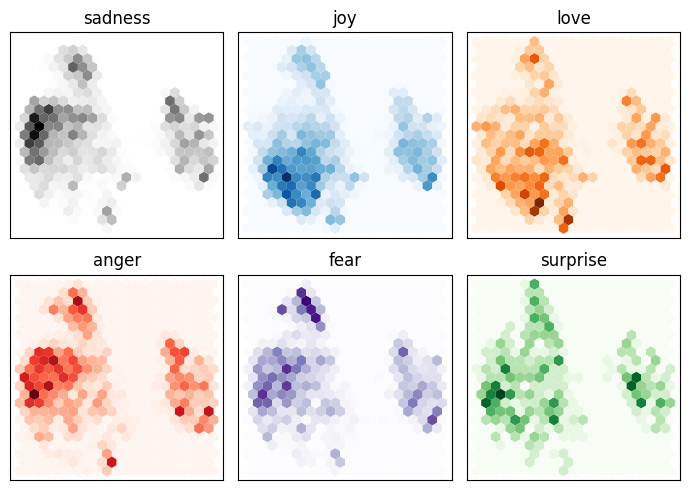

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps = ['Greys', 'Blues', 'Oranges', 'Reds', 'Purples', 'Greens']
labels = emotions['train'].features['label'].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f'label == {i}')
    axes[i].hexbin(df_emb_sub['X'], df_emb_sub['Y'], 
                   cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show() 

### Entrainement d'un classificateur simple

In [36]:
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6335

In [ ]:
dummy_clf = DummyClassifier

## Fine tuning